In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import os
import zipfile

# Text processing and classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
)

# Plotting
import matplotlib.pyplot as plt

# Image processing
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Deep learning with TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    TerminateOnNaN,
    LearningRateScheduler,
    CSVLogger,
    TensorBoard,
    ReduceLROnPlateau,
    EarlyStopping,
)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
import os
import shutil
import random

# Define the base dataset directory and the target directory
base_dir = "/kaggle/input/disaster-dataset-broad/Comprehensive Disaster Dataset(CDD)/"
target_dir = "/kaggle/working/"

# Create target directories for train, val, and test
os.makedirs(os.path.join(target_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'test'), exist_ok=True)

# Set the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure that the ratios add up to 1
assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1"

# Loop through each class directory
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    
    if os.path.isdir(class_path):  # Check if it is a directory
        # Get a list of all images in the class directory
        images = os.listdir(class_path)
        random.shuffle(images)  # Shuffle the images for randomness
        
        # Calculate the number of images for each split
        total_images = len(images)
        train_count = int(total_images * train_ratio)
        val_count = int(total_images * val_ratio)
        
        # Split images into train, val, and test
        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]

        # Create class directories in target directories
        os.makedirs(os.path.join(target_dir, 'train', class_name), exist_ok=True)
        os.makedirs(os.path.join(target_dir, 'val', class_name), exist_ok=True)
        os.makedirs(os.path.join(target_dir, 'test', class_name), exist_ok=True)

        # Move the images to the corresponding directories
        for image in train_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(target_dir, 'train', class_name, image))

        for image in val_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(target_dir, 'val', class_name, image))

        for image in test_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(target_dir, 'test', class_name, image))

print("Dataset has been split into train, val, and test sets.")

Dataset has been split into train, val, and test sets.


In [4]:

train_dir = '/kaggle/working/train/'
val_dir = '/kaggle/working/val/'
test_dir = '/kaggle/working/test/'

def check_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()  # Verify if the image is valid
            except Exception as e:
                os.remove(img_path)
                print(f"Corrupted image: {img_path}, Error: {e}")

check_images(train_dir)  # Check your train directory
check_images(val_dir)    # Check your validation directory
check_images(test_dir)   # Check your test directory
print("CHECK DONE")

Corrupted image: /kaggle/working/test/Human_Damage/02_0069.png, Error: cannot identify image file '/kaggle/working/test/Human_Damage/02_0069.png'
CHECK DONE


In [5]:
#!rm /kaggle/working/test/Human_Damage/02_0069.png

rm: cannot remove '/kaggle/working/test/Human_Damage/02_0069.png': No such file or directory


In [ ]:
'''import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths for training, validation, and test data
train_dir = '/kaggle/working/train/'
val_dir = '/kaggle/working/val/'
test_dir = '/kaggle/working/test/'

# Image dimensions and other parameters
img_height, img_width = 150, 150  # You can adjust this based on your needs
batch_size = 32

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data preparation for validation and test sets
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Use 'binary' for binary classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for evaluation
)

# Define a simple CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10  # You can adjust the number of epochs
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.2f}')

# Make predictions (optional)
# predictions = model.predict(test_generator)'''


In [ ]:
#model.save('image_classification_model.h5')  # Save the model to an HDF5 file#

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_model(model, test_generator):
    # Make predictions
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)  # If using softmax output; adjust for binary/multiclass
    true_classes = test_generator.classes  # Actual labels from the test generator

    # Calculate metrics
    accuracy = np.mean(predicted_classes == true_classes)
    precision = precision_score(true_classes, predicted_classes, average='macro')
    recall = recall_score(true_classes, predicted_classes, average='macro')
    f1 = f1_score(true_classes, predicted_classes, average='macro')
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    
    # Specificity calculation
    specificity = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])  # True Negative Rate

    # AUC-ROC calculation for multi-class
    true_classes_bin = label_binarize(true_classes, classes=np.unique(true_classes))
    n_classes = true_classes_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_classes_bin[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class')
    plt.legend(loc='lower right')
    plt.show()

    # Print all evaluation metrics
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall (Sensitivity): {recall:.2f}')
    print(f'F1-Score: {f1:.2f}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f'Specificity (True Negative Rate): {specificity:.2f}')
    print('Classification Report:')
    print(classification_report(true_classes, predicted_classes))



In [12]:
# Define paths for the callback directories
print("MODEL START DONE")
checkpoint_dir = '/kaggle/working/checkpoints/'
logs_dir = '/kaggle/working/logs/'
training_log_dir = '/kaggle/working/training_log/'

# Create the directories if they don't exist
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(training_log_dir, exist_ok=True)

seed_value = 97  # You can choose any integer
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)




# Set paths for training, validation, and test data
train_dir = '/kaggle/working/train/'
val_dir = '/kaggle/working/val/'
test_dir = '/kaggle/working/test/'

# Image dimensions and other parameters
img_height, img_width = 150, 150  # You can adjust this based on your needs
batch_size = 32

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data preparation for validation and test sets
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Use 'binary' for binary classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for evaluation
)

# Load the VGG19 model, excluding the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add your custom layers on top of the VGG19 model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# Now define your callbacks using the created directories
checkpoint = ModelCheckpoint(os.path.join(checkpoint_dir, 'best_model.keras'), monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6)
tensorboard = TensorBoard(log_dir=logs_dir, histogram_freq=1)
csv_logger = CSVLogger(os.path.join(training_log_dir, 'training.log'))

def scheduler(epoch, lr):
    if epoch > 5:
        return float(lr * tf.math.exp(-0.1))
    return lr

lr_scheduler = LearningRateScheduler(scheduler)
terminate_on_nan = TerminateOnNaN()



# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=1,  # You can adjust the number of epochs
    callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard,csv_logger,lr_scheduler,terminate_on_nan]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.2f}')

# Make predictions (optional)
# predictions = model.predict(test_generator)


MODEL START DONE
Found 9485 images belonging to 6 classes.
Found 2031 images belonging to 6 classes.
Found 2040 images belonging to 6 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728112103.877596     179 service.cc:145] XLA service 0x7c43d4004c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728112103.877656     179 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728112103.877661     179 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728112112.369842     179 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7027 - loss: 0.9623

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


296/296 ━━━━━━━━━━━━━━━━━━━━ 95s 279ms/step - accuracy: 0.7029 - loss: 0.9615 - val_accuracy: 0.8021 - val_loss: 0.5807 - learning_rate: 0.0010
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - accuracy: 0.6561 - loss: 0.9570
Test accuracy: 0.81
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step


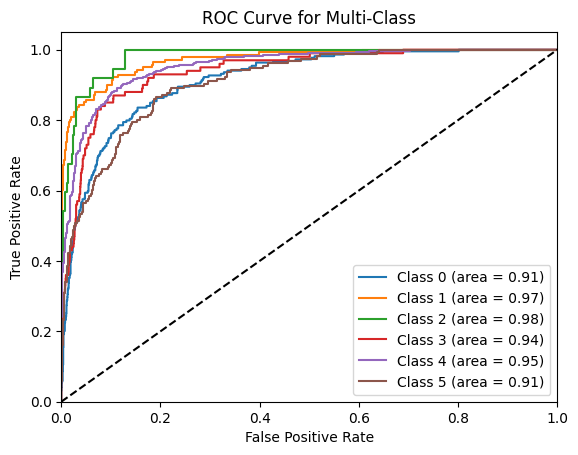

Accuracy: 0.81
Precision: 0.74
Recall (Sensitivity): 0.52
F1-Score: 0.57
Confusion Matrix:
[[  69   12    1    0  129    8]
 [   3  116    2    0   19    1]
 [   8    4   12    0   11    2]
 [  10   18    0   27   27   18]
 [   3   16    0    2 1362    4]
 [   6   16    0    3   70   61]]
Specificity (True Negative Rate): 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.32      0.43       219
           1       0.64      0.82      0.72       141
           2       0.80      0.32      0.46        37
           3       0.84      0.27      0.41       100
           4       0.84      0.98      0.91      1387
           5       0.65      0.39      0.49       156

    accuracy                           0.81      2040
   macro avg       0.74      0.52      0.57      2040
weighted avg       0.80      0.81      0.78      2040



In [18]:
evaluate_model(model, test_generator)

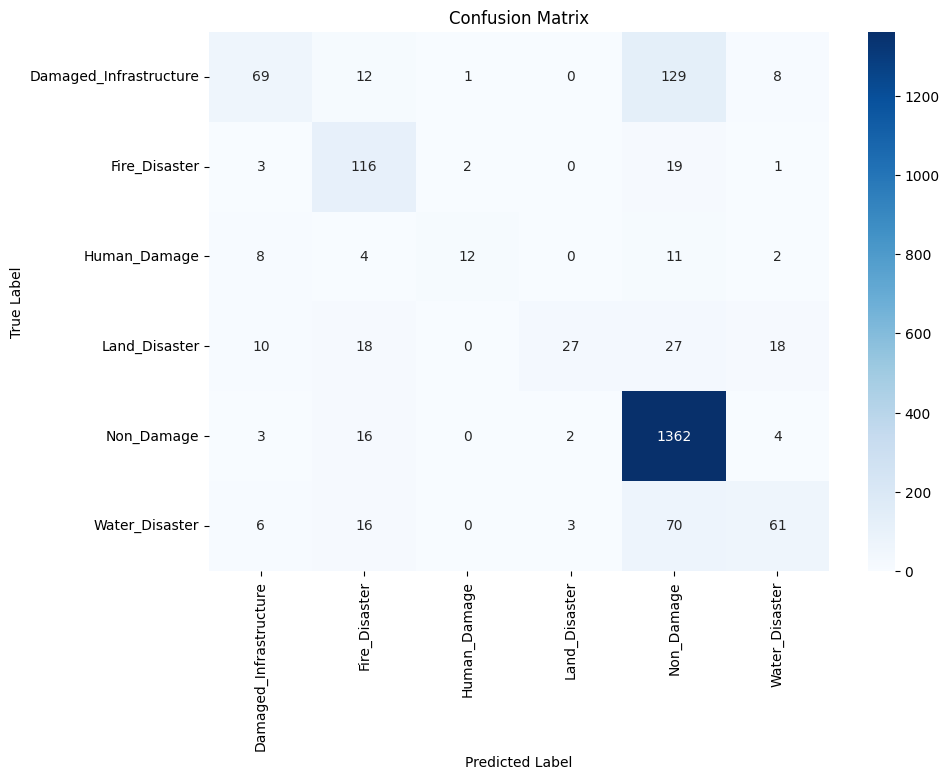

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
confusion_matrix = np.array([[  69,   12,    1,    0,  129,    8],
                              [   3,  116,    2,    0,   19,    1],
                              [   8,    4,   12,    0,   11,    2],
                              [  10,   18,    0,   27,   27,   18],
                              [   3,   16,    0,    2, 1362,    4],
                              [   6,   16,    0,    3,   70,   61]])

# Define class labels
class_labels = ['Damaged_Infrastructure', 'Fire_Disaster', 'Human_Damage', 'Land_Disaster', 'Non_Damage', 'Water_Disaster']

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
class_names = train_generator.class_indices
print(class_names)

In [ ]:
model.save('/kaggle/working/my_final_model.keras')  # Save as .keras format


In [ ]:
model_path = '/kaggle/working/my_final_model.keras'
zip_file_path = '/kaggle/working/my_final_model.zip'

# Create a zip file containing the model
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    zipf.write(model_path, os.path.basename(model_path))